# Compare Twitter and Reddit Populations

## Analyis of Popularly Shared Domains

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [2]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
from utils.youtube import strip_video_id_from_url

In [5]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

def links_to_norm_matrix(links_df, domains, user_id_field):
    if ( type(domains) == set ):
        domains = list(domains)
        
    shares_df = links_df_to_shares(links_df, domains, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[domains], norm="l2", axis=1)

def get_top_channels(yt_df, user_id_field, top_n=100):
    channel_user_counts = {}
    for channel, group in yt_df.groupby("channel_id"):
        local_users = set(group[user_id_field])
        channel_user_counts[channel] = len(local_users)

    return sorted(channel_user_counts, key=channel_user_counts.get, reverse=True)[:top_n]

def channels_df_to_shares(links_df, channels, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_chan_counts = dict(user_posts["channel_id"].value_counts().items())
        local_vector = [local_chan_counts.get(x, 0) for x in channels]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + channels)

def channels_to_norm_matrix(links_df, channels, user_id_field):
    if ( type(channels) == set ):
        channels = list(channels)
        
    shares_df = channels_df_to_shares(links_df, channels, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[channels], norm="l2", axis=1)


In [6]:
top_n_domains = 150
top_n_channels = 250
bootstrap_count = 5000

In [7]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [8]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [9]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [10]:
twitter_top_tlds_rand = get_top_tlds(twitter_links_df_rand, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_poli = get_top_tlds(twitter_links_df_poli, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_ira = get_top_tlds(twitter_links_df_ira, user_id_field="user_id", top_n=top_n_domains)

top_tld_map_twitter = {
    "random": set(twitter_top_tlds_rand),
    "political": set(twitter_top_tlds_poli),
    "ira": set(twitter_top_tlds_ira),
}

for population, tlds in top_tld_map_twitter.items():
    print(population, ":", len(tlds))


random : 150
political : 150
ira : 150


In [11]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [12]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [13]:
reddit_top_tlds_rand = get_top_tlds(reddit_links_df_rand, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_poli = get_top_tlds(reddit_links_df_poli, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_ira = get_top_tlds(reddit_links_df_ira, user_id_field="user_name", top_n=top_n_domains)

top_tld_map_reddit = {
    "random": set(reddit_top_tlds_rand),
    "political": set(reddit_top_tlds_poli),
    "ira": set(reddit_top_tlds_ira),
}

for population, tlds in top_tld_map_reddit.items():
    print(population, ":", len(tlds))


random : 150
political : 150
ira : 150


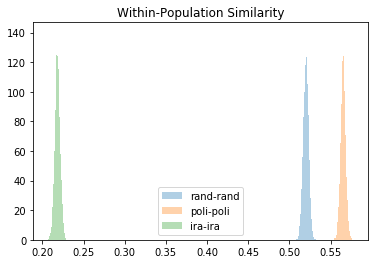

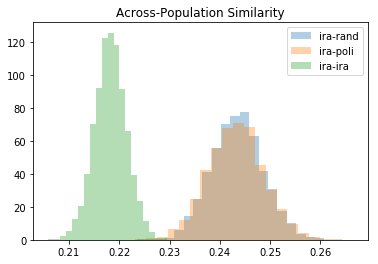

In [14]:
twitter_overlap_rand_poli = top_tld_map_twitter["random"].intersection(top_tld_map_twitter["political"])
twitter_overlap_rand_ira = top_tld_map_twitter["random"].intersection(top_tld_map_twitter["ira"])
twitter_overlap_poli_ira = top_tld_map_twitter["political"].intersection(top_tld_map_twitter["ira"])

twitter_user_links_mat_rand = links_to_norm_matrix(twitter_links_df_rand, top_tld_map_twitter["random"], "user_id")
twitter_user_links_mat_poli = links_to_norm_matrix(twitter_links_df_poli, top_tld_map_twitter["political"], "user_id")
twitter_user_links_mat_ira = links_to_norm_matrix(twitter_links_df_ira, top_tld_map_twitter["ira"], "user_id")

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, twitter_overlap_rand_ira, "user_id"), 
    links_to_norm_matrix(twitter_links_df_rand, twitter_overlap_rand_ira, "user_id"))
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, twitter_overlap_poli_ira, "user_id"), 
    links_to_norm_matrix(twitter_links_df_poli, twitter_overlap_poli_ira, "user_id"))
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_rand, twitter_overlap_rand_poli, "user_id"), 
    links_to_norm_matrix(twitter_links_df_poli, twitter_overlap_rand_poli, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [15]:
print("Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), np.array(t2t_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), np.array(t2t_ira_ira_sim_avg_bootstrap).var())


Random: 0.5197741616680875 1.0367137683065641e-05
Political: 0.5651738142298864 9.41180442585607e-06
Russian IRA: 0.21823731254493847 1.0216117030487735e-05


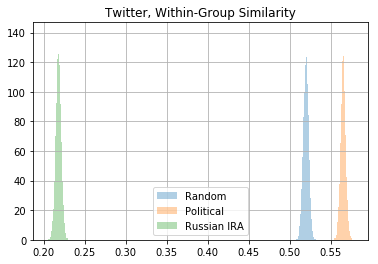

In [16]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA")

plt.title("Twitter, Within-Group Similarity")
plt.legend()
plt.grid()
plt.show()

In [17]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 17778583.543940794
p-value for Welch's t-Test between Rand and IRA: 0.0 4699.210900518076
p-value for Welch's t-Test between Poli and IRA: 0.0 5536.743540514204


In [18]:
print("Random-Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.5197741616680875 1.0367137683065641e-05
Russian IRA-Random: 0.24346287196151353 2.641120525672841e-05
Russian IRA-Political: 0.24317744072041023 3.123515395032964e-05


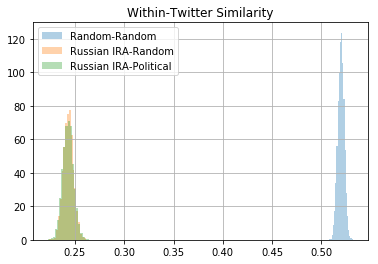

In [19]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [21]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 5617384.510641805
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.00787287544092615 2.658013194590604


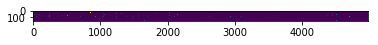

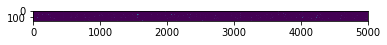

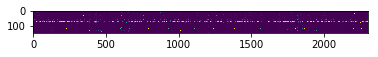

In [22]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

In [23]:
for label, mat in [
    ("random", twitter_user_links_mat_rand), 
    ("political", twitter_user_links_mat_poli), 
    ("ira", twitter_user_links_mat_ira)]:
    print(label)
    domains = top_tld_map_twitter[label]
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

random
	 twitter.com 0.6826234536295309
	 instagram.com 0.14165043011258188
	 vine.co 0.12953519471514205
	 youtube.com 0.10393103758900007
	 facebook.com 0.06292637780920862
	 twimg.com 0.0180263431352453
	 fllwrs.com 0.016284621419212823
	 soundcloud.com 0.01621665695480661
	 nytimes.com 0.013378782725450879
	 linkedin.com 0.008970181694513716
political
	 twitter.com 0.717695187321102
	 instagram.com 0.13532539099808355
	 youtube.com 0.12276327760759255
	 facebook.com 0.09629823314330088
	 nytimes.com 0.041410057383605
	 washingtonpost.com 0.025941067674274974
	 linkedin.com 0.024213242265329483
	 cnn.com 0.020505105391794266
	 foxnews.com 0.020144798438039447
	 wordpress.com 0.016710920750515022
ira
	 youtube.com 0.36921451198461447
	 twitter.com 0.21050501799363489
	 vine.co 0.13219800168901588
	 instagram.com 0.07440082890164003
	 hugedomains.com 0.07150347274800165
	 vimeo.com 0.043576062238581646
	 telegraph.co.uk 0.03757703660729419
	 cnn.com 0.0349070723491845
	 facebook.com 0

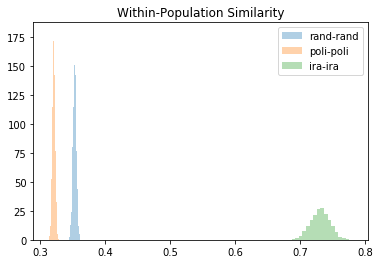

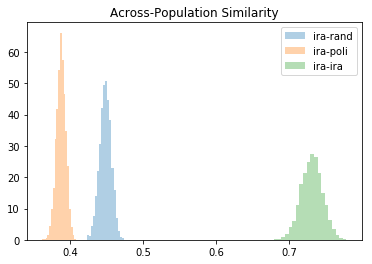

In [24]:
reddit_overlap_rand_poli = top_tld_map_reddit["random"].intersection(top_tld_map_reddit["political"])
reddit_overlap_rand_ira = top_tld_map_reddit["random"].intersection(top_tld_map_reddit["ira"])
reddit_overlap_poli_ira = top_tld_map_reddit["political"].intersection(top_tld_map_reddit["ira"])

reddit_user_links_mat_rand = links_to_norm_matrix(reddit_links_df_rand, top_tld_map_reddit["random"], "user_name")
reddit_user_links_mat_poli = links_to_norm_matrix(reddit_links_df_poli, top_tld_map_reddit["political"], "user_name")
reddit_user_links_mat_ira = links_to_norm_matrix(reddit_links_df_ira, top_tld_map_reddit["ira"], "user_name")

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, reddit_overlap_rand_ira, "user_name"), 
    links_to_norm_matrix(reddit_links_df_rand, reddit_overlap_rand_ira, "user_name"))
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, reddit_overlap_poli_ira, "user_name"), 
    links_to_norm_matrix(reddit_links_df_poli, reddit_overlap_poli_ira, "user_name"))
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_rand, reddit_overlap_rand_poli, "user_name"), 
    links_to_norm_matrix(reddit_links_df_poli, reddit_overlap_rand_poli, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [25]:
print("Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), np.array(r2r_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), np.array(r2r_ira_ira_sim_avg_bootstrap).var())


Random: 0.35285995712364204 6.907722655714354e-06
Political: 0.32067456971565733 5.138849663630833e-06
Russian IRA: 0.7307151953042004 0.0002143525316777379


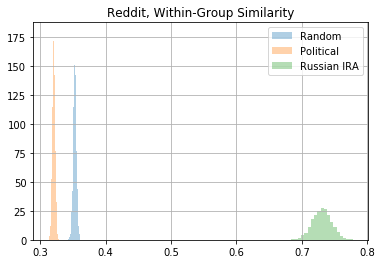

In [26]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA")

plt.title("Reddit, Within-Group Similarity")
plt.legend()
plt.grid()
plt.show()

In [27]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 3443933.7496369183
p-value for Welch's t-Test between Rand and IRA: 0.0 -1796.037135009908
p-value for Welch's t-Test between Poli and IRA: 0.0 -1956.8598378481001


In [28]:
print("Random-Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())



Random-Random: 0.35285995712364204 6.907722655714354e-06
Russian IRA-Random: 0.4479321364228621 6.179622466780175e-05
Russian IRA-Political: 0.3872137199913651 4.05443302790041e-05


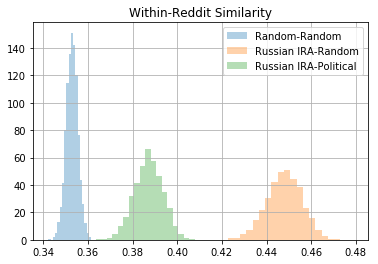

In [29]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [30]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 318147.92813319474
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 424.36359605963764


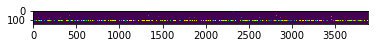

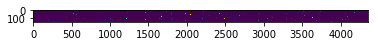

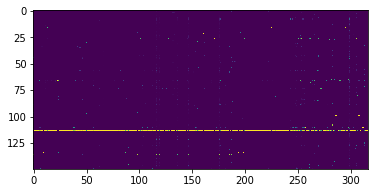

In [31]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

In [32]:
for label, mat in [
    ("random", reddit_user_links_mat_rand), 
    ("political", reddit_user_links_mat_poli), 
    ("ira", reddit_user_links_mat_ira)]:
    print(label)
    domains = top_tld_map_reddit[label]
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

random
	 imgur.com 0.4737527287971037
	 reddit.com 0.25768228579346075
	 youtube.com 0.23756387012319036
	 reddituploads.com 0.056878463266534465
	 twitter.com 0.03341750831472496
	 gfycat.com 0.01824719390847289
	 soundcloud.com 0.01239962516853127
	 twitch.tv 0.010897501669416075
	 google.com 0.010447119079280615
	 tumblr.com 0.009129117854910036
political
	 imgur.com 0.40468899062641556
	 youtube.com 0.28430269093835836
	 reddit.com 0.25238929889653716
	 twitter.com 0.06569168376073894
	 reddituploads.com 0.039553904693199575
	 sli.mg 0.039070573076228896
	 washingtonpost.com 0.031041417341425754
	 nytimes.com 0.02705095530920743
	 cnn.com 0.02164238018488441
	 wikipedia.org 0.014329531940238885
ira
	 imgur.com 0.852507911912021
	 butthis.com 0.03570594882081377
	 youtube.com 0.02496696051307701
	 reddit.com 0.02480158957418954
	 blackmattersus.com 0.02374693901824808
	 twitter.com 0.013450401047130009
	 livejournal.com 0.009420801021552504
	 vine.co 0.008291347641471082
	 huffingto

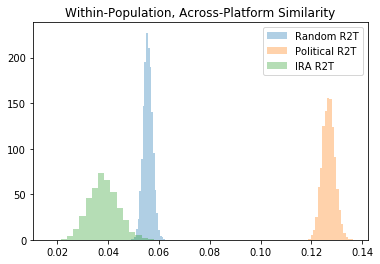

In [33]:
r2t_overlap_rand = top_tld_map_reddit["random"].intersection(top_tld_map_twitter["random"])
r2t_overlap_poli = top_tld_map_reddit["political"].intersection(top_tld_map_twitter["political"])
r2t_overlap_ira = top_tld_map_reddit["ira"].intersection(top_tld_map_twitter["ira"])

r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_rand, r2t_overlap_rand, "user_name"), 
    links_to_norm_matrix(twitter_links_df_rand, r2t_overlap_rand, "user_id"))
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_poli, r2t_overlap_poli, "user_name"), 
    links_to_norm_matrix(twitter_links_df_poli, r2t_overlap_poli, "user_id"))
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, r2t_overlap_ira, "user_name"), 
    links_to_norm_matrix(twitter_links_df_ira, r2t_overlap_ira, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [34]:
print("Random-R2T:", np.array(r2t_rand_sim_avg_bootstrap).mean(), np.array(r2t_rand_sim_avg_bootstrap).var())
print("Political-R2T:", np.array(r2t_poli_sim_avg_bootstrap).mean(), np.array(r2t_poli_sim_avg_bootstrap).var())
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())



Random-R2T: 0.055737753431520806 3.154446521761649e-06
Political-R2T: 0.1267393669776205 6.1796458181660355e-06
Russian IRA-R2T: 0.03832291737986141 3.254586655212967e-05


In [38]:
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())
print("Russian IRA-RRandom:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-RPoli:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Russian IRA-R2T: 0.03832291737986141 3.254586655212967e-05
Russian IRA-RRandom: 0.4479321364228621 6.179622466780175e-05
Russian IRA-RPoli: 0.3872137199913651 4.05443302790041e-05


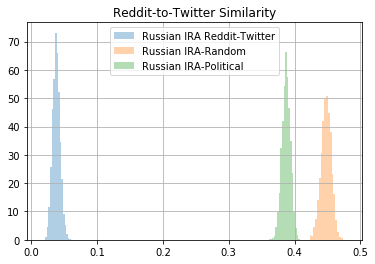

In [39]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Reddit-Twitter")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Reddit-to-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [45]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 5432952.202718347
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 -2981.6629011423843
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 -2885.3700762362555


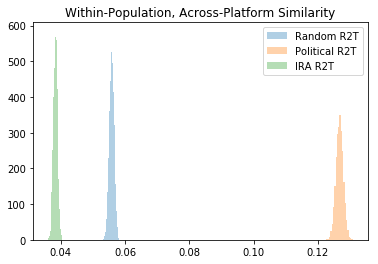

In [41]:
t2r_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_rand, r2t_overlap_rand, "user_id"), 
    links_to_norm_matrix(reddit_links_df_rand, r2t_overlap_rand, "user_name"))
t2r_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_poli, r2t_overlap_poli, "user_id"), 
    links_to_norm_matrix(reddit_links_df_poli, r2t_overlap_poli, "user_name"))
t2r_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, r2t_overlap_ira, "user_id"), 
    links_to_norm_matrix(reddit_links_df_ira, r2t_overlap_ira, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
t2r_rand_sim_avg = np.mean(t2r_rand_sim, axis=1)
t2r_poli_sim_avg = np.mean(t2r_poli_sim, axis=1)
t2r_ira_sim_avg = np.mean(t2r_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
t2r_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2r_rand_sim_avg, replace=True, n_samples=t2r_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2r_poli_sim_avg, replace=True, n_samples=t2r_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2r_ira_sim_avg, replace=True, n_samples=t2r_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2r_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(t2r_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



In [42]:
print("Russian IRA-T2R:", np.array(t2r_ira_sim_avg_bootstrap).mean(), np.array(t2r_ira_sim_avg_bootstrap).var())
print("Russian IRA-TRandom:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-TPoli:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Russian IRA-T2R: 0.0383521612892692 4.2320465683282575e-07
Russian IRA-TRandom: 0.24346287196151353 2.641120525672841e-05
Russian IRA-TPoli: 0.24317744072041023 3.123515395032964e-05


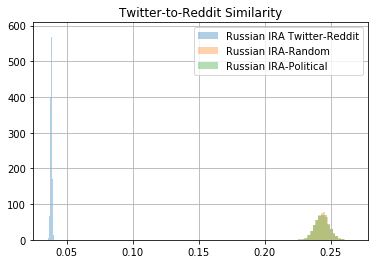

In [43]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Twitter-Reddit")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Twitter-to-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [46]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 3616656.8952701767
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 -2799.521988376719
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 -2573.8363334312176


In [47]:
## Full Cross-Comparison

### Other comparisons
t2t_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_poli_sim_avg, replace=True, n_samples=t2t_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_poli_sim_avg, replace=True, n_samples=r2r_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]




In [48]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)


	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: 0.35285995712364204 6.907722655714354e-06 0.3390995644910164 5.481621930731165e-06 0.4479321364228621 6.179622466780175e-05 0.055737753431520806 3.154446521761649e-06
Political: 0.3390995644910164 5.481621930731165e-06 0.32067456971565733 5.138849663630833e-06 0.3872137199913651 4.05443302790041e-05 0.1267393669776205 6.1796458181660355e-06
IRA: 0.4479321364228621 6.179622466780175e-05 0.3872137199913651 4.05443302790041e-05 0.7307151953042004 0.0002143525316777379 0.03832291737986141 3.254586655212967e-05
Twitter
Random: 0.5197741616680875 1.0367137683065641e-05 0.54228016128541 1.1011503940144687e-05 0.24346287196151353 2.641120525672841e-05 0.05577269932343115 5.680418764081314e-07
Political: 0.54228016128541 1.1011503940144687e-05 0.5651738142298864 9.41180442585607e-06 0.24317744072041023 3.123515395032964e-05 0.12674999500594517 1.3080360284829494e-06
IRA: 0.24346287196151353 2.6411

### Compare Identically Named Users

In [49]:
reddit_troll_names = pd.read_csv("../data/reddit_troll_accounts_20190206.csv")
twitter_troll_names = pd.read_csv("../data/twitter_russian_troll_accounts.csv")

In [50]:
cross_platform_users = set(twitter_troll_names["handle"].apply(str.lower))\
    .intersection(set(reddit_troll_names["username"].apply(str.lower)))

print("User count with the same ID:", len(cross_platform_users))
for u in cross_platform_users:
    print(u)

User count with the same ID: 19
stephenbag
deusxyx
blacktolive
jenn_abrams
ten_gop
markhudson89
toneporter
bleepthepolice
leecory
fuuncake
1488reasons
mr_clampin
southlonestar
dorothiebell
hyddrox
wadeharriot
rebekahbennet
matevidence
tebepizdec


In [51]:
deanon_df = pd.read_csv("../data/deanon_v2.csv")

In [52]:
deanon_map = {row["screen_name"].lower():row["userid"] for _, row in deanon_df.iterrows()}

In [53]:
for u in cross_platform_users:
    print(u, deanon_map.get(u))
    

stephenbag None
deusxyx 99299a75c967aa491b27d86a60c2ffe0a6156d1b0dcb4487917f48e7e1c7ef78
blacktolive None
jenn_abrams None
ten_gop None
markhudson89 None
toneporter cd2f120a1666c87fac2ab045e1ff01b06be0814481d4e96234a13041b3a1a295
bleepthepolice None
leecory None
fuuncake None
1488reasons None
mr_clampin b61d47c22efd69b47675c296d5c54e2675da8977504225327611713990b4e784
southlonestar None
dorothiebell dfcf2c9017b25c825fa444e17e429f3a6e739bc44ca7db41645470fe4410ad25
hyddrox 396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e
wadeharriot 349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869
rebekahbennet None
matevidence None
tebepizdec None


In [54]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    print(u, deanon_map.get(u))
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)
    print("\t", "Twitter TLDs:", len(local_twitter_tld), "Reddit TLDs:", len(local_reddit_tld))
    print("\t", "TLDs in Common:", len(common_tlds))

    if ( len(common_tlds) == 0 ):
        continue
        
    local_sim = sklearn.metrics.pairwise.cosine_similarity(
        links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
        links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
    print("\t", "Local Similarity:", local_sim)

stephenbag None
deusxyx 99299a75c967aa491b27d86a60c2ffe0a6156d1b0dcb4487917f48e7e1c7ef78
	 Twitter TLDs: 305 Reddit TLDs: 0
	 TLDs in Common: 0
blacktolive None
jenn_abrams None
ten_gop None
markhudson89 None
toneporter cd2f120a1666c87fac2ab045e1ff01b06be0814481d4e96234a13041b3a1a295
	 Twitter TLDs: 47 Reddit TLDs: 14
	 TLDs in Common: 2
	 Local Similarity: [[1.]]
bleepthepolice None
leecory None
fuuncake None
1488reasons None
mr_clampin b61d47c22efd69b47675c296d5c54e2675da8977504225327611713990b4e784
	 Twitter TLDs: 72 Reddit TLDs: 9
	 TLDs in Common: 0
southlonestar None
dorothiebell dfcf2c9017b25c825fa444e17e429f3a6e739bc44ca7db41645470fe4410ad25
	 Twitter TLDs: 480 Reddit TLDs: 0
	 TLDs in Common: 0
hyddrox 396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e
	 Twitter TLDs: 1386 Reddit TLDs: 12
	 TLDs in Common: 9
	 Local Similarity: [[0.54646406]]
wadeharriot 349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869
	 Twitter TLDs: 502 Reddit TLDs: 9
	 TLDs in 

In [55]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)

    sim = 0.0
    if ( len(common_tlds) > 0 ):
        local_sim = sklearn.metrics.pairwise.cosine_similarity(
            links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
            links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
        sim = local_sim[0]
        
    print("%s & %d & %d & %d & %f \\\\" % (u, len(local_reddit_tld), len(local_twitter_tld), len(common_tlds), sim))
    

deusxyx & 0 & 305 & 0 & 0.000000 \\
toneporter & 14 & 47 & 2 & 1.000000 \\
mr_clampin & 9 & 72 & 0 & 0.000000 \\
dorothiebell & 0 & 480 & 0 & 0.000000 \\
hyddrox & 12 & 1386 & 9 & 0.546464 \\
wadeharriot & 9 & 502 & 8 & 0.804273 \\
